Importa as bibliotecas necessárias para o pré-processamento do Dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

Carrega o Dataset bruto

In [5]:
df_prop = pd.read_excel('dataset_full_feats.xlsx')

Visualiza informações básicas do conteúdo do Dataset

In [6]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46319 entries, 0 to 46318
Data columns (total 11 columns):
COD_PROP    46319 non-null int64
ANO         46319 non-null int64
NUM_PROP    46319 non-null int64
NOM_PROP    46319 non-null object
TEMAS       46319 non-null object
POLITICO    33402 non-null object
SEXO        33402 non-null object
PARTIDO     33333 non-null object
UF          33380 non-null object
REGIAO      33380 non-null object
TEXTO       46319 non-null object
dtypes: int64(3), object(8)
memory usage: 3.9+ MB


In [7]:
df_prop.head(3)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO
0,133436,2003,1989,PL 1989/2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR (UT...",RONALDO VASCONCELLOS,M,PTB,MINAS GERAIS,SUDESTE,Dispõe sobre o prazo para devolução de encomen...
1,132228,2003,1923,PL 1923/2003,ARTE E CULTURA,BETO ALBUQUERQUE,M,PSB,RIO GRANDE DO SUL,SUL,Confere ao município de Passo Fundo o título d...
2,118055,2003,1165,PL 1165/2003,ARTE E CULTURA,ELIMAR MÁXIMO DAMASCENO,M,PRONA,SÃO PAULO,SUDESTE,Inscreve o nome de Heitor Villa-Lobos no Livro...


Identifica a quantidade total de temas presentes no Dataset

In [8]:
df_prop['TEMAS'].nunique()

585

Elimina o texto "(UTILIZADO ATE A LEGISLATURA 53)" existente em alguns nomes de temas para melhorar visualização e operação com os temas.

In [9]:
for index, tema in df_prop.iterrows():
    legis_53 = '(UTILIZADO ATE A LEGISLATURA 53)'
    if legis_53 in tema['TEMAS']:
        tema_processado = tema['TEMAS'].replace(legis_53, '')
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_processado

In [10]:
df_prop.head(1)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO
0,133436,2003,1989,PL 1989/2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR",RONALDO VASCONCELLOS,M,PTB,MINAS GERAIS,SUDESTE,Dispõe sobre o prazo para devolução de encomen...


In [11]:
df_prop['TEMAS'].nunique()

585

Mostra a quantidade de entradas para cada um dos temas existentes

In [12]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                                                                   8466
TRABALHO E EMPREGO                                                                             2455
ADMINISTRACAO PUBLICA                                                                          2356
EDUCACAO                                                                                       2073
TRIBUTACAO                                                                                     2056
DIREITO PENAL E PROCESSUAL PENAL                                                               1788
SAUDE                                                                                          1539
DIREITOS HUMANOS, MINORIAS E CIDADANIA                                                         1439
VIACAO E TRANSPORTES                                                                           1359
HOMENAGENS E DATAS COMEMORATIVAS                                                               1219


Identificado diversos temas que possuem subtemas e portanto estão sendo identificados pelo código como categorias distintas. 
Para resolver isso o código abaixo agrega todos os temas que possuem subtemas em seu tema primário, salvo algumas exceções.

In [13]:
excecoes = ['RECURSOS HIDRICOS, MINERAIS E POLITICA ENERGETICA', 
            'DIREITOS HUMANOS, MINORIAS E CIDADANIA', 
            'ORGANIZACAO POLITICA, PARTIDARIA E ELEITORAL',
            'ECONOMIA, ADMINISTRACAO FINANCEIRA E ORCAMENTARIA',
            'INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR', 
            'INDUSTRIA, COMERCIO E ABASTECIMENTO',
            'AGRICULTURA, PECUARIA E PESCA']
for index, tema in df_prop.iterrows():
    virgula = ','
    if virgula in tema['TEMAS']:
        if not tema['TEMAS'] in excecoes and not tema['TEMAS'].startswith(str(map(lambda e: e, excecoes))): 
            tema_principal = tema['TEMAS'].split(',')[0]
            if tema_principal.endswith(' '):
                tema_principal = tema_principal.rstrip(' ')
            df_prop.at[df_prop.index[index], 'TEMAS'] = tema_principal

In [14]:
df_prop['TEMAS'].nunique()

47

In [15]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                         8854
ADMINISTRACAO PUBLICA                                3565
TRABALHO E EMPREGO                                   2591
EDUCACAO                                             2510
DIREITO PENAL E PROCESSUAL PENAL                     2318
TRIBUTACAO                                           2136
SAUDE                                                1799
INDUSTRIA                                            1612
DIREITO CIVIL E PROCESSUAL CIVIL                     1536
DESENVOLVIMENTO URBANO E TRANSITO                    1465
DIREITOS HUMANOS, MINORIAS E CIDADANIA               1439
VIACAO E TRANSPORTES                                 1359
HOMENAGENS E DATAS COMEMORATIVAS                     1262
PREVIDENCIA E ASSISTENCIA SOCIAL                     1259
DIREITOS HUMANOS                                     1173
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL          1063
SEGURANCA PUBLICA                                    1023
ORGANIZACAO PO

Realiza correções de nomes e agrega ainda mais algumas categorias para reduzir o número de Temas criando

In [16]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO ADMINISTRATIVA DO ESTADO'
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS'] and tema['TEMAS'].startswith(tema_chave):
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

In [17]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO '
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS'] and tema['TEMAS'].startswith(tema_chave):
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

In [18]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('INDUSTRIA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'INDUSTRIA E COMERCIO'

In [19]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('CIENCIA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'CIENCIA E TECNOLOGIA'

In [20]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('INFORMATICA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'CIENCIA E TECNOLOGIA'

In [21]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('RECURSOS HIDRICOS'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'RECURSOS HIDRICOS, MINERAIS E POLITICA ENERGETICA'

In [22]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('AGRICULTURA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'AGRICULTURA, PECUARIA E PESCA'

In [23]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('DIREITOS HUMANOS'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'DIREITOS HUMANOS'

In [24]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('ORGANIZACAO POLITICA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'

In [25]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('POLITICA ECONOMICA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'ECONOMIA'

In [26]:
df_prop['TEMAS'].nunique()

36

In [27]:
df_prop.to_excel('Dataset_processed.xlsx',sheet_name='Dataset')

In [28]:
df_prop.sort_values(by='TEMAS', ascending=True, inplace=True)

In [29]:
df_prop.count()

COD_PROP    46319
ANO         46319
NUM_PROP    46319
NOM_PROP    46319
TEMAS       46319
POLITICO    33402
SEXO        33402
PARTIDO     33333
UF          33380
REGIAO      33380
TEXTO       46319
dtype: int64

Visualiza a distribuição das entradas entre os TEMAS

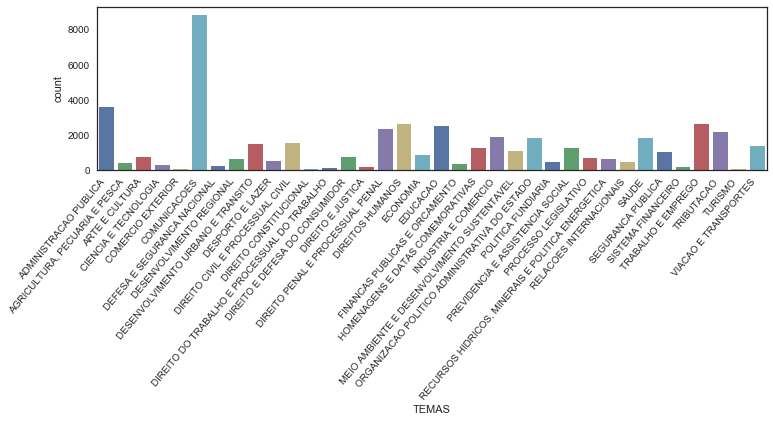

In [30]:
sns.set_context("notebook")
sns.set_style('white')
plt.figure(figsize=(12,3))
countplot = sns.countplot(x=df_prop['TEMAS'], data=df_prop, palette='deep')
plt.setp(countplot.get_xticklabels(), rotation=50, ha="right")
countplot

Verifica distribuição das entradas

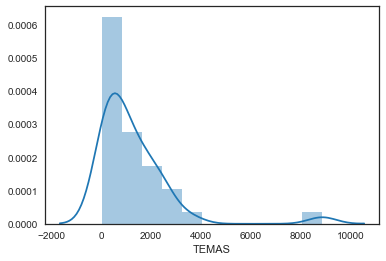

In [31]:
sns.distplot(df_prop['TEMAS'].value_counts())

Exibe a distribuição em porcentagem dos temas dentro do dataset

In [32]:
df_prop['TEMAS'].value_counts(normalize=True) * 100

COMUNICACOES                                         19.115266
ADMINISTRACAO PUBLICA                                 7.696626
DIREITOS HUMANOS                                      5.639155
TRABALHO E EMPREGO                                    5.593817
EDUCACAO                                              5.418943
DIREITO PENAL E PROCESSUAL PENAL                      5.004426
TRIBUTACAO                                            4.611499
INDUSTRIA E COMERCIO                                  4.013472
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         3.976770
SAUDE                                                 3.883935
DIREITO CIVIL E PROCESSUAL CIVIL                      3.316134
DESENVOLVIMENTO URBANO E TRANSITO                     3.162849
VIACAO E TRANSPORTES                                  2.934001
HOMENAGENS E DATAS COMEMORATIVAS                      2.724584
PREVIDENCIA E ASSISTENCIA SOCIAL                      2.718107
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL           2

In [33]:
df_prop['TEXTO'].nunique()

44107

In [34]:
d_count = 0
d_list = df_prop['TEXTO'].duplicated()
d_list.dtype

dtype('bool')

Carrega arquivo do dataset que teve o texto já processado e tokenizado para análise

In [35]:
df_tokenized = pd.read_excel('Processed_File.xlsx')

In [36]:
df_tokenized['TOKENIZED'].describe()

count                              46319
unique                             40866
top        dá nov red art constitu feder
freq                                 123
Name: TOKENIZED, dtype: object

Pegas os indices de todas as entradas que estão duplicadas no dataset

In [37]:
duplicated_entries = []
for idx, v in df_tokenized.duplicated(subset='TOKENIZED', keep='first').iteritems():
    if v is True:
        duplicated_entries.append(idx)

Remove os itens duplicados do dataset

In [38]:
for idx, values in df_tokenized.iterrows():
    if idx in duplicated_entries:
        df_tokenized.drop(labels=idx, axis=0, inplace=True)

In [39]:
df_tokenized['TOKENIZED'].describe()

count                                                 40866
unique                                                40866
top        acrescent art títul vii capítul ii seç ii da ...
freq                                                      1
Name: TOKENIZED, dtype: object

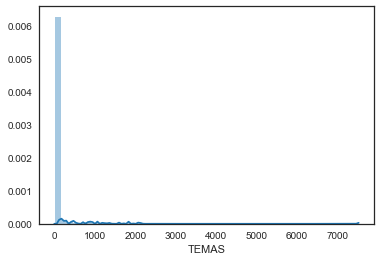

In [40]:
sns.distplot(df_tokenized['TEMAS'].value_counts())

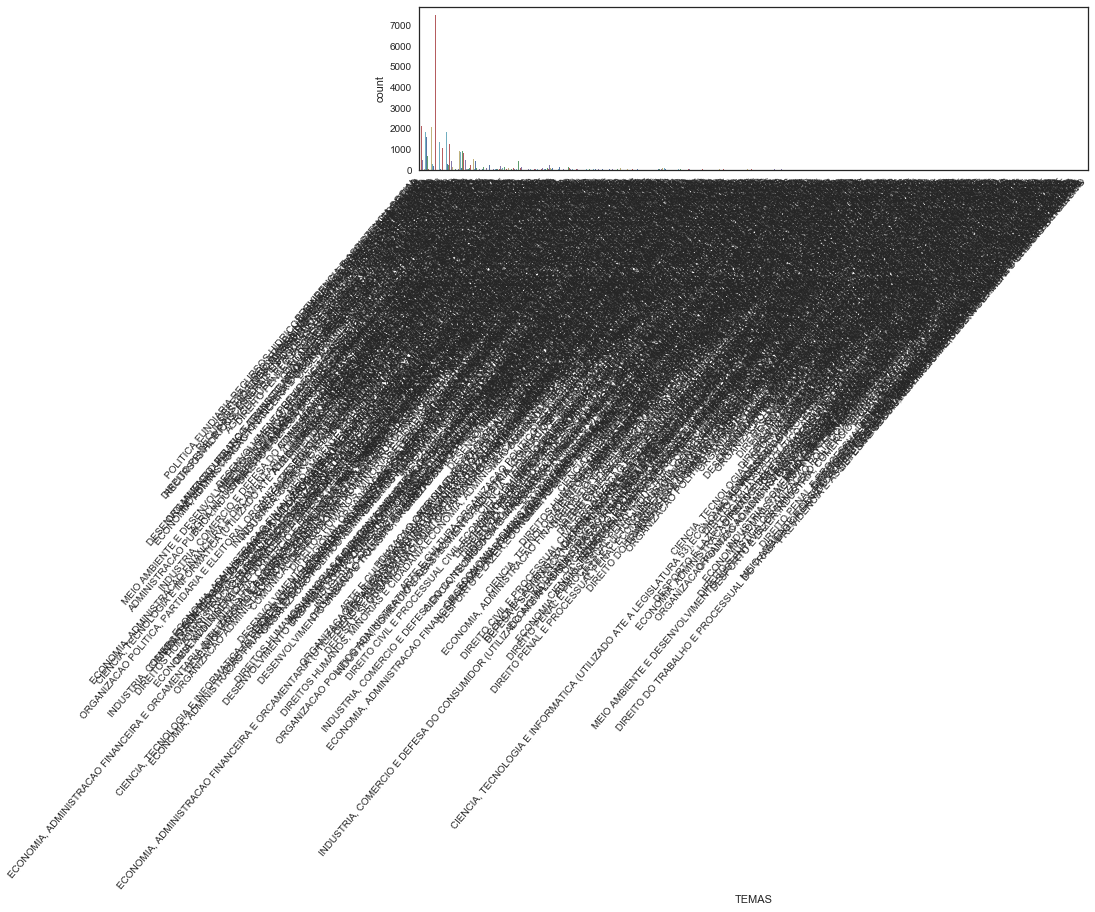

In [41]:
sns.set_context("notebook")
sns.set_style('white')
plt.figure(figsize=(12,3))
countplot = sns.countplot(x=df_tokenized['TEMAS'], data=df_tokenized, palette='deep')
plt.setp(countplot.get_xticklabels(), rotation=50, ha="right")
countplot

Distribuição em % dos TEMAS após limpeza de entradas duplicadas
Resultado: Ainda há uma discrepância grande entre representatividade das classes

In [42]:
df_tokenized['TEMAS'].value_counts(normalize=True) * 100

COMUNICACOES                                                                                                                                             18.394264
TRABALHO E EMPREGO                                                                                                                                        5.221945
ADMINISTRACAO PUBLICA                                                                                                                                     5.048206
EDUCACAO                                                                                                                                                  4.531885
TRIBUTACAO                                                                                                                                                4.448686
DIREITO PENAL E PROCESSUAL PENAL                                                                                                                          3.861401
SAUDE                 

**A seguir será analisado a correlação de outras variáveis com os TEMAS:**

Correlação de variáveis adicionais com TEMAS:

Carrega o dataset com oas novas variáveis

In [43]:
#dataset_full = pd.read_excel('dataset_full_feats.xlsx')
dataset_full = df_prop

Transformando as variáveis categóricas textuais em códigos para que possa ser calculado a correlação entre elas

In [44]:
#Cria novas variáveis com os códigos das categorias existentes
v_categ = ['TEMAS', 'POLITICO', 'SEXO', 'PARTIDO', 'UF', 'REGIAO']
prefix = 'CODE_'
corr_df_prop = dataset_full.copy()
for categ in v_categ:
    nv_categ = prefix + categ
    corr_df_prop[nv_categ] = dataset_full[categ]
    corr_df_prop[nv_categ] = pd.Categorical(corr_df_prop[nv_categ])
    corr_df_prop[nv_categ] = corr_df_prop[nv_categ].cat.codes

#Exibe a correlação:
corr_df_prop.corr()

,COD_PROP,ANO,NUM_PROP,CODE_TEMAS,CODE_POLITICO,CODE_SEXO,CODE_PARTIDO,CODE_UF,CODE_REGIAO
COD_PROP,1.000000,0.802261,0.026947,0.025664,0.118076,0.166733,0.159458,0.112276,0.120856
ANO,0.802261,1.000000,0.066040,0.036024,0.138859,0.171667,0.182300,0.126465,0.116366
NUM_PROP,0.026947,0.066040,1.000000,0.136674,0.117009,0.187467,0.119641,0.188661,0.186643
CODE_TEMAS,0.025664,0.036024,0.136674,1.000000,0.244531,0.368859,0.240344,0.307875,0.318741
CODE_POLITICO,0.118076,0.138859,0.117009,0.244531,1.000000,0.627560,0.462729,0.507170,0.514783
CODE_SEXO,0.166733,0.171667,0.187467,0.368859,0.627560,1.000000,0.650071,0.741863,0.772424
CODE_PARTIDO,0.159458,0.182300,0.119641,0.240344,0.462729,0.650071,1.000000,0.562842,0.561659
CODE_UF,0.112276,0.126465,0.188661,0.307875,0.507170,0.741863,0.562842,1.000000,0.821303
CODE_REGIAO,0.120856,0.116366,0.186643,0.318741,0.514783,0.772424,0.561659,0.821303,1.000000


Abaixo o Heatmap das correlações entre as variáveis. No que diz respeito aos temas, as características com maior correlação são SEXO, UF e REGIAO com valores dentro entre 0.3 e 0.4, seguido pelo POLITICO e PARTIDO, ambos com 0.25. 

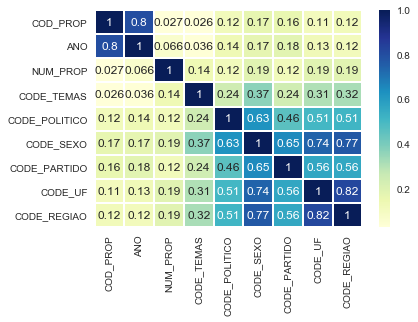

In [66]:
sns.heatmap(corr_df_prop.corr(), cmap='YlGnBu',linecolor='white',linewidths=1, annot=True)

In [46]:
corr_df_prop.head(3)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO,CODE_TEMAS,CODE_POLITICO,CODE_SEXO,CODE_PARTIDO,CODE_UF,CODE_REGIAO
46318,149439,2003,2794,PL 2794/2003,ADMINISTRACAO PUBLICA,TADEU FILIPPELLI,M,PMDB,DISTRITO FEDERAL,CENTRO-OESTE,"Dispõe sobre a alteração da Lei nº 8.666, de 2...",0,1269,1,9,6,0
33669,475193,2010,7239,PL 7239/2010,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Acrescenta art. 31-A à Lei nº 8.987, de 13 de ...",0,-1,-1,-1,-1,-1
33674,585601,2013,6004,PL 6004/2013,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Regulamenta o art. 37, inciso II, da Constitui...",0,-1,-1,-1,-1,-1


Trata os valores nulos da coluna SEXO

In [61]:
corr_df_prop['SEXO'].fillna(value='NaN', method=None, inplace=True)

In [63]:
corr_df_prop['SEXO'].isnull().sum()

0

Exporta para o Excel após correção dos valores nulos na coluna SEXO

In [64]:
df_prop.to_excel('Dataset_processed.xlsx',sheet_name='Dataset')

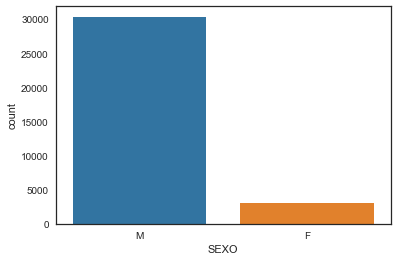

In [48]:
sns.countplot(x='SEXO',data=corr_df_prop)

In [49]:
corr_df_prop['SEXO'].value_counts()

M    30351
F     3051
Name: SEXO, dtype: int64

Analisando quantidade de politicos por sexo:

In [50]:
print('Sexo Feminino: ' + str(corr_df_prop[corr_df_prop['SEXO'] == 'F']['POLITICO'].nunique()) +'\n'+
      'Sexo Masculino: ' + str(corr_df_prop[corr_df_prop['SEXO'] == 'M']['POLITICO'].nunique()))

Sexo Feminino: 137
Sexo Masculino: 1268


Visualizando a distribuição de proposições por tema e sexo:

In [51]:
print('SEXO FEMININO')
temas_f_perc = corr_df_prop[corr_df_prop['SEXO'] == 'F']['TEMAS'].value_counts(normalize=True) * 100
temas_f_perc

SEXO FEMININO


DIREITOS HUMANOS                                     12.651590
EDUCACAO                                              8.292363
ADMINISTRACAO PUBLICA                                 7.997378
TRABALHO E EMPREGO                                    7.767945
SAUDE                                                 6.588004
DIREITO PENAL E PROCESSUAL PENAL                      5.801377
HOMENAGENS E DATAS COMEMORATIVAS                      4.588659
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         4.195346
TRIBUTACAO                                            3.769256
DESENVOLVIMENTO URBANO E TRANSITO                     3.441495
INDUSTRIA E COMERCIO                                  3.375942
PREVIDENCIA E ASSISTENCIA SOCIAL                      3.310390
DIREITO CIVIL E PROCESSUAL CIVIL                      3.080957
COMUNICACOES                                          2.720420
SEGURANCA PUBLICA                                     2.458210
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL           2

In [52]:
print('SEXO MASCULINO')
temas_m_perc = corr_df_prop[corr_df_prop['SEXO'] == 'M']['TEMAS'].value_counts(normalize=True) * 100
temas_m_perc

SEXO MASCULINO


ADMINISTRACAO PUBLICA                                8.029389
TRABALHO E EMPREGO                                   6.978353
DIREITOS HUMANOS                                     6.530263
EDUCACAO                                             6.167836
DIREITO PENAL E PROCESSUAL PENAL                     6.111825
TRIBUTACAO                                           6.082172
INDUSTRIA E COMERCIO                                 5.169517
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO        4.935587
SAUDE                                                4.859807
DIREITO CIVIL E PROCESSUAL CIVIL                     4.250272
DESENVOLVIMENTO URBANO E TRANSITO                    4.190966
VIACAO E TRANSPORTES                                 3.891140
PREVIDENCIA E ASSISTENCIA SOCIAL                     3.281605
HOMENAGENS E DATAS COMEMORATIVAS                     3.156403
COMUNICACOES                                         2.958716
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL          2.945537
SEGURANC

In [53]:
corr_df_prop[corr_df_prop['SEXO'] == 'M']['PARTIDO'].value_counts(normalize=True) * 100

PMDB       13.882835
PT         11.095700
PSDB       10.306453
PP          7.123043
PDT         5.468595
PSB         5.346410
DEM         5.108645
PFL         5.092134
PR          4.725580
PSD         4.494419
PTB         4.451489
PL          4.217027
PPS         3.308896
PV          2.754111
PSC         2.397464
PRB         2.390859
PCDOB       1.274685
SD          1.010501
PPB         0.653854
PSOL        0.640645
PROS        0.597715
PHS         0.584506
PMN         0.425996
PTDOB       0.392973
PTC         0.307113
PRONA       0.287299
S.PART.     0.280695
PSL         0.221254
PRTB        0.211347
REDE        0.168417
PTN         0.138696
SDD         0.135394
PMB         0.118883
PRP         0.102371
PST         0.092464
PEN         0.072650
PSDC        0.052837
PAN         0.046232
PMR         0.019814
Name: PARTIDO, dtype: float64

In [54]:
corr_df_prop[(corr_df_prop['SEXO'] == 'M') & (corr_df_prop['ANO'] == 2016)]['TEMAS'].value_counts(normalize=True) * 100

DIREITOS HUMANOS                                     10.268780
ADMINISTRACAO PUBLICA                                 9.235010
DIREITO PENAL E PROCESSUAL PENAL                      8.545830
DESENVOLVIMENTO URBANO E TRANSITO                     6.960717
SAUDE                                                 5.651275
TRIBUTACAO                                            5.582357
DIREITO CIVIL E PROCESSUAL CIVIL                      4.617505
COMUNICACOES                                          4.410751
DIREITO E DEFESA DO CONSUMIDOR                        4.135079
TRABALHO E EMPREGO                                    4.135079
EDUCACAO                                              3.790489
PREVIDENCIA E ASSISTENCIA SOCIAL                      2.963473
INDUSTRIA E COMERCIO                                  2.825637
SEGURANCA PUBLICA                                     2.618884
HOMENAGENS E DATAS COMEMORATIVAS                      2.481048
RECURSOS HIDRICOS, MINERAIS E POLITICA ENERGETICA     2